# Baseline solution for seismic facies identification challenge

### Architecture: U-Net
### Language: Tensorflow/keras

#### Considerations about the project:
 - Goals of project: Create a machine learning algorithm which, working from the raw 3D image, can reproduce an expert pixel-by-pixel identification.
 - Meaning of 3D Images: Seismic images of underground structures made during exploration of underground reservoirs (Sounds waves are sent to the ground and the echoes return to the surface. Then, the echoes are processed into three dimensional images highlighting interfaces between rocks with different properties)
 - Meaning of facies: The sum total characteristics of a rock that distinguishes it from adjacent rock
 - Challenge: Label each pixel (voxel) in a 3D seismic image of underground geological structures according to these 6 facies
 - Dataset: "Parihak",a 3D seismic image from a public-domain seismic survey

### Dependencies

In [1]:
import tensorflow as tf
import keras as K
from keras.layers import Input, BatchNormalization, Dropout, Dense, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model

import numpy as np
from mayavi import mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import cv2
import time


import jaccard_loss as jc

### Dataset

In [2]:
# load data
data_train = np.load('./dataset/data_train.npz')['data']
label_train = np.load('./dataset/labels_train.npz')['labels']
print(data_train.shape) # (Z,X,Y)
print(label_train.shape) # (Z,X,Y)

(1006, 782, 590)
(1006, 782, 590)


In [ ]:
# Plot 3d Visualizations
fig= mlab.figure(figure='seismic', bgcolor=(1, 1, 1), fgcolor=(0,0,0))
scalars = np.swapaxes(np.swapaxes(data_train,0,1),1,2)# specifying the data array
mlab.volume_slice(scalars, slice_index=0, plane_orientation='x_axes', figure=fig)   # crossline slice
mlab.volume_slice(scalars, slice_index=0,  plane_orientation='y_axes', figure=fig)   # inline slice
mlab.volume_slice(scalars, slice_index=0, plane_orientation='z_axes', figure=fig)   # depth slice
mlab.axes(xlabel='Inline', ylabel='Crossline', zlabel='Depth', nb_labels=6) # Add axes labels 
mlab.show()

Text(0.5, 1.0, 'Ground Truth')

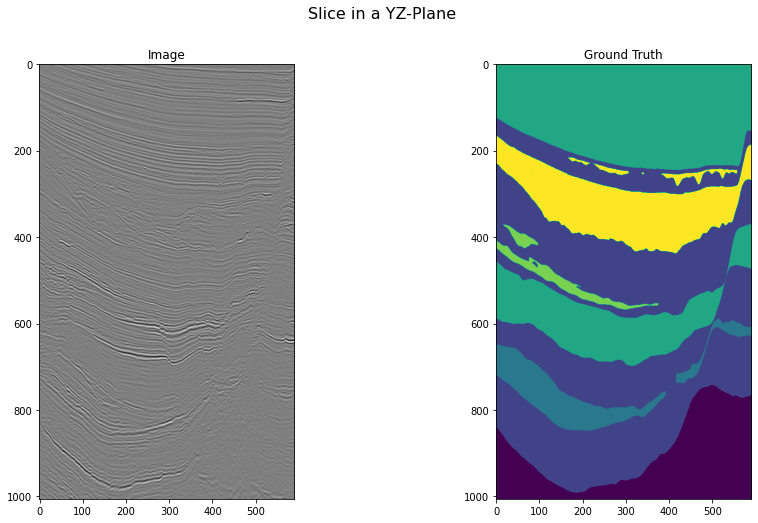

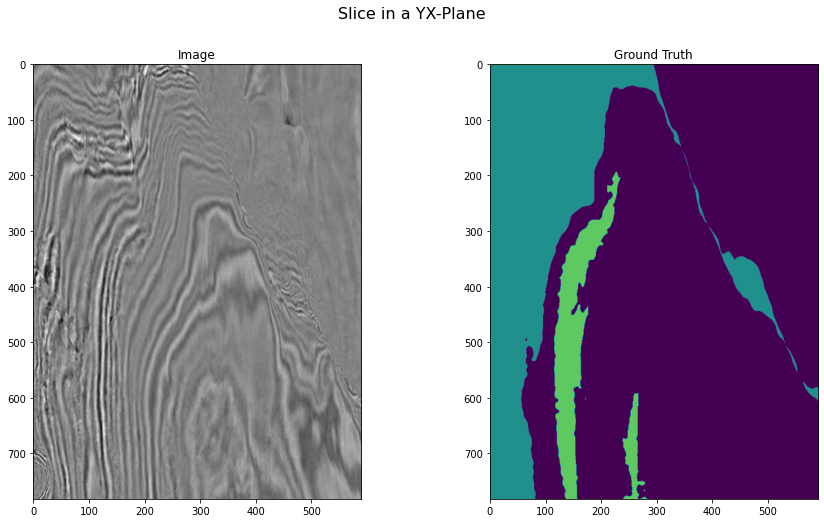

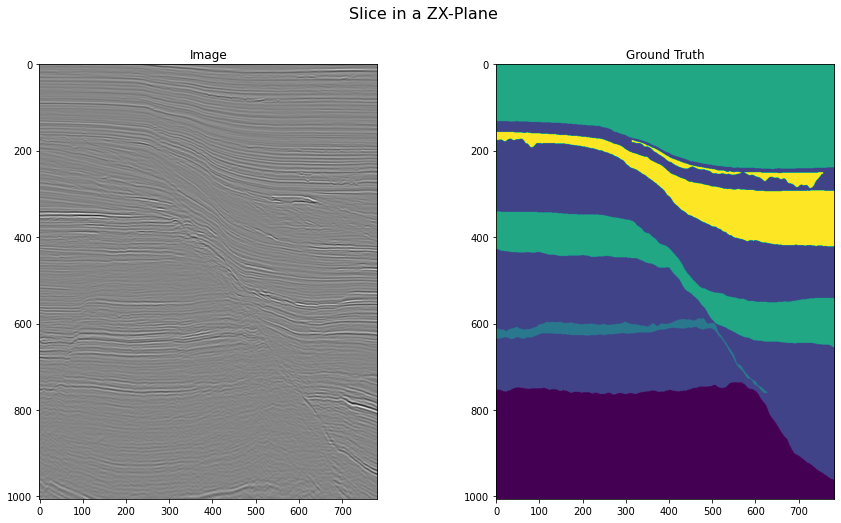

In [3]:
# Plot 2d Visualizations
data_to_plot = data_train
label_to_plot = label_train

fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a YZ-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(data_to_plot[:,500,:],cmap='gray')
ax.set_title('Image')

ax1 = fig.add_subplot(122)
ax1.imshow(label_to_plot[:,500,:])
ax1.set_title('Ground Truth')

fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a YX-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(data_to_plot[500,:,:],cmap='gray')
ax.set_title('Image')

ax1 = fig.add_subplot(122)
ax1.imshow(label_to_plot[500,:,:])
ax1.set_title('Ground Truth')

fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a ZX-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(data_to_plot[:,:,500],cmap='gray')
ax.set_title('Image')

ax1 = fig.add_subplot(122)
ax1.imshow(label_to_plot[:,:,500])
ax1.set_title('Ground Truth')

### Define Network architecture

In [4]:
# defines convolutional block

def conv2d_block(input_tensor,n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(n_filters, (kernel_size,kernel_size),padding='same',\
               kernel_initializer='he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same',\
               kernel_initializer='he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# defines encoder and decoder block
def encoder_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = conv2d_block(input_tensor, n_filters, kernel_size=kernel_size, batchnorm=batchnorm)
    p = MaxPooling2D((2,2))(x)
    return x,p

def decoder_block(input_tensor, n_filters, skip_features, kernel_size=3, batchnorm=True):
    x = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=2, padding="same")(input_tensor)
    x = concatenate([x,skip_features])
    x = conv2d_block(x, n_filters, kernel_size=kernel_size, batchnorm=batchnorm)
    return x

# defines unet architecture
#img_input = Input(input_shape)/ out_channel = number of classes

def unet(img_input_shape, out_channel, n_filters=64, k_size=3, batchnorm = True):
    img_input = Input(img_input_shape)
    
    c1, p1 = encoder_block(img_input, n_filters*1, kernel_size=k_size, batchnorm=batchnorm)
    c2, p2 = encoder_block(p1, n_filters*2, kernel_size=k_size, batchnorm=batchnorm)
    c3, p3 = encoder_block(p2, n_filters*4, kernel_size=k_size, batchnorm=batchnorm)
    c4, p4 = encoder_block(p3, n_filters*8, kernel_size=k_size, batchnorm=batchnorm)
    
    
    c5 = conv2d_block(p4, n_filters*16, kernel_size=k_size, batchnorm=batchnorm)
    
    c6 = decoder_block(c5, n_filters*8, c4, kernel_size=k_size, batchnorm=batchnorm)
    c7 = decoder_block(c6, n_filters*4, c3, kernel_size=k_size, batchnorm=batchnorm)
    c8 = decoder_block(c7, n_filters*2, c2, kernel_size=k_size, batchnorm=batchnorm)
    c9 = decoder_block(c8, n_filters*1, c1, kernel_size=k_size, batchnorm=batchnorm)
    
    outputs = Conv2D(out_channel, 1, activation='softmax')(c9) #multiclass segmentation
    model = Model(inputs= img_input, outputs= outputs, name ='U-Net')
    
    return model

## Data pre-processing

In [5]:
def input_crop(data, labels, cropsize, stride):

    img_patches = []
    label_patches = []

    for depth in range(0, data.shape[0]):
        img = data[depth, :, :]
        label = labels[depth, :, :]

        n_crops_x = int(((img.shape[0] - cropsize[0])/stride[1]) + 1) # similar to feature map calculation with zero padding
        n_crops_y = int(((img.shape[1] - cropsize[1])/stride[1]) + 1)
        for i in range(0, n_crops_x):
            for j in range(0,n_crops_y):
                img_patches.append(img[i*stride[0] : cropsize[0]+(i*stride[0]), j*stride[1] : cropsize[1]+(j*stride[1])])

                if  i == n_crops_x-1 and cropsize[0]+(i*stride[0]) < img.shape[0]:
                    img_patches.append(img[img.shape[0] - cropsize[0]: img.shape[0], j*stride[1] : cropsize[1]+(j*stride[1])])
                if  j == n_crops_y-1 and cropsize[1]+(j*stride[1]) < img.shape[1]:
                    img_patches.append(img[i*stride[0] : cropsize[0]+(i*stride[0]), img.shape[1] - cropsize[1]: img.shape[1]])


                label_patches.append(label[i*stride[0] : cropsize[0]+(i*stride[0]), j*stride[1] : cropsize[1]+(j*stride[1])])

                if  i == n_crops_x-1 and cropsize[0]+(i*stride[0]) < label.shape[0]:
                    label_patches.append(label[label.shape[0] - cropsize[0]: label.shape[0], j*stride[1] : cropsize[1]+(j*stride[1])])

                if  j == n_crops_y-1 and cropsize[1]+(j*stride[1]) < label.shape[1]:
                    label_patches.append(label[i*stride[0] : cropsize[0]+(i*stride[0]), label.shape[1] - cropsize[1]: label.shape[1]])
                    
    return img_patches, label_patches

In [6]:
def preprocess_data(images):  # images = a list with all arrays (train and test images)
    # min_img = min(list(map(lambda x: x.min(), images)))
    # max_img = max(list(map(lambda x: x.max(), images)))
    # Normalize values to min and max
    # normalized_images = list(map(lambda x: (x - min_img) / (max_img - min_img), images))
    # Normalize values 0 to 255.0
    normalized_images = list(map(lambda x: (x * 255.0) / x.max(), images))
    colors_images = list(map(lambda m: convert_1_to_3_channel(m), normalized_images))
    #preprocessing_images = list(map(lambda y: preproc(y.astype("float32")), colors_images))
    return colors_images


def convert_1_to_3_channel(input):
    rgb_input = []
    for i in range(0, len(input)):
        rgb_input.append(skimage.color.gray2rgb(input[i]))
    return np.array(rgb_input)

In [8]:
import skimage.color

cropsize = (256,256)
stride = (256,256)

In [9]:
img_raw_crop, label_raw_crop = input_crop(data_train,label_train,cropsize, stride)
crops_img = np.array(preprocess_data(images=np.array(img_raw_crop)))

# convert label from (1 to 6) to (0 to 5) and expand dims
crops_label = np.array([*map((lambda x: np.expand_dims(x-1,2)),label_raw_crop)])

In [10]:
print('Classes: ', np.unique(crops_label))
n_classes = len(np.unique(crops_label))

Classes:  [0 1 2 3 4 5]


In [11]:
#clean memory
del img_raw_crop, label_raw_crop, data_train, label_train

Text(0.5, 1.0, 'Ground Truth')

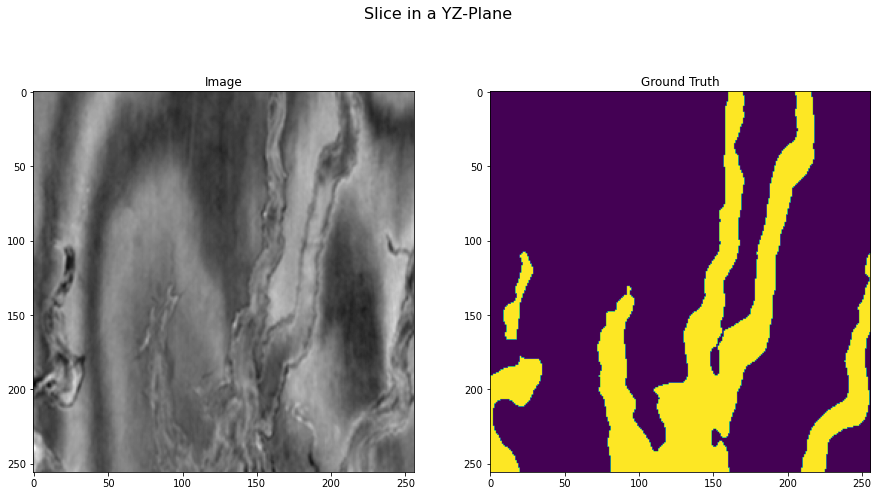

In [10]:
# plot one crop (image and label)
fig = plt.figure(figsize=(15,8))

fig.suptitle('Slice in a YZ-Plane', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(img_crop[3000][:,:,0],cmap='gray')
ax.set_title('Image')

ax1 = fig.add_subplot(122)
ax1.imshow(label_crop[3000][:,:,0])
ax1.set_title('Ground Truth')

In [12]:
from keras import backend as Kb
def jacard_coef(y_true,y_pred):
    y_true = Kb.flatten(y_true)
    y_pred = Kb.flatten(y_pred)
    intersection = Kb.sum(y_true*y_pred)
    return (intersection + 1.0)/(Kb.sum(y_true) + Kb.sum(y_pred) - intersection + 1.0)

def jacard_coef_loss(y_true,y_pred):
    return - jacard_coef(y_true, y_pred)

In [17]:
# Random crop:
#idx = list(range(len(np.array(crop_scale))))
#idx = random.sample(idx,len(idx))
#crops_img = np.array(crop_scale)[idx].astype("float32")
#crops_label = np.array(label_crop)[idx].astype("float32") #.astype("int16")

In [13]:
# Split image in train and val
total = len(crops_img)
split = int(total*0.5)

val_image = crops_img[split:]
train_image = crops_img[:split]
val_label = crops_label[split:]
train_label = crops_label[:split]

#del crops_img, crops_label

In [16]:
del crops_img, crops_label

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_label, num_classes=n_classes)

In [18]:
# Define model
cropsize = [256,256]
lr = 0.0001
n_classes = 7
y_true = Input(shape=(cropsize[0],cropsize[1],1), name='y_true',dtype=tf.int8)

model = unet([cropsize[0],cropsize[1],3],5)
model = Model(inputs=model.inputs, outputs=model.outputs)

# Optimizer
optim = tf.keras.optimizers.Adam(lr)

# Define loss 
#loss = generalized_dice_loss_w(y_true, model.get_layer("softmax").output)
#model.add_loss(loss)
#jaccard_loss = jc.dice_coef_9cat_loss(y_true, model.output)

#iou = jc.iou_score(y_true, model.output, n_classes, class_weights=1.)[0]
#print('iou',iou)

#dice_loss = sm.losses.DiceLoss(class_weights=weights) 
#model.add_loss(jaccard_loss)

#model.add_metric(iou, name=iou)

#metrics = [tf.keras.metrics.MeanIoU(num_classes=7)]

#model.compile(optimizer= optim, loss= None, metrics=metrics)
model.compile(optimizer=optim, loss= [jacard_coef_loss], metrics= [jacard_coef])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

 spose)                         8)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 25  0           ['conv2d_transpose_2[0][0]',     
                                6)                                'activation_3[0][0]']           
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 12  295040      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 12  512        ['conv2d_15[0][0]']              
 ormalization)                  8)                                                                
          

In [26]:
loss_history = []
acc_history = []
iou_history = []
num_epochs = 5
batch_size = 64
n_batches_train = len(train_image)//batch_size
n_batches_val = len(val_image)//batch_size


for epoch in range(num_epochs):
    print('Starting epoch {}-{}'.format(epoch+1, num_epochs))
    batch_start = 0 # Initial batch value of j epoch
    batch_end = batch_size  # Initial batch end of j epoch
    loss = 0
    iou_train = 0
    previous_loss = 99999 # initial previous_loss to put loss_val
    previous_loss_val = 99999
    
    start_time = time.time()
    for i in range(n_batches_train):
        history = model.train_on_batch(x=train_image[batch_start:batch_end],
                                        y=train_label[batch_start:batch_end]
                                       )
        #print(history)
        batch_start+=batch_size
        batch_end+=batch_size
        loss+=history[0]
        iou_train += history[1]
    end_time = time.time()
    print("epoch time: ",end_time - start_time)
    
    loss = loss/n_batches_train # Average loss function of all batches in j epoch (train)
    iou_train = iou_train/n_batches_train # Average IOU of all batches in j epoch (train)
    
    #Val
    
    batch_start_val = 0
    batch_end_val = batch_size
    loss_val = 0
    iou_val = 0
    
    for i in range(n_batches_val):  
        history_val = model.test_on_batch(x=val_image[batch_start_val:batch_end_val],
                                           y=val_label[batch_start_val:batch_end_val]
                                         )
        batch_start_val+=batch_size
        batch_end_val+=batch_size
        loss_val+=history_val[0]
        iou_val += history_val[1]
        
    loss_val = loss_val/n_batches_val
    iou_val = iou_val/n_batches_val
    
    if loss_val < previous_loss_val:
        model.save_weights('diceloss_unet_' + str(cropsize)+ "_" + backbone_net + "_nclass_"
                           + str(n_classes) + '_seg_' + 'weights.h5')
        previous_loss_val = loss_val
        
    if loss < previous_loss:
        model.save_weights('diceloss_unet_' + str(cropsize) + "_" + backbone_net + "_nclass_" 
                           + str(n_classes) + '_seg_' + 'weights_best_Train.h5')
        loss_ant = loss


    print("loss train: ",loss)
    print("iou train: ",iou_train)
    print("loss val: ",loss_val)

Starting epoch 1-5


TypeError: in user code:

    File "/home/catarina/anaconda3/envs/self_supervised_segmentation/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-11-cb2079aa7bed>", line 9, in jacard_coef_loss  *
        return - jacard_coef(y_true, y_pred)
    File "<ipython-input-11-cb2079aa7bed>", line 5, in jacard_coef  *
        intersection = Kb.sum(y_true*y_pred)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int8 of argument 'x'.
